## Downloading the Dataset

Before doing this, you have to get your kaggle API key and your kaggle username and set it to the google colab secrets as "KAGGLE_USERNAME" and "KAGGLE_KEY".

In [ ]:
import os
from google.colab import userdata
import zipfile

os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

# This step needs to be done after the environment variables have been set, as it will raise an error, if it does not find the variables or a kaggle.json file
from kaggle.api.kaggle_api_extended import KaggleApi

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download dataset
competition_name = 'global-wheat-detection'
api.competition_download_files(competition_name, path=os.getcwd())
print(f"Dataset '{competition_name}' downloaded successfully.")

extract_dir = "global_wheat_detection"

zip_file_path = "global-wheat-detection.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'.")

Dataset 'global-wheat-detection' downloaded successfully.
Successfully extracted 'global-wheat-detection.zip' to 'global_wheat_detection'.


## Dataset Class

I have used a dictionary because multiple bounding boxes may exist for every image. 

In [1]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import ast  # For safely evaluating the string representation of the list in bbox
from torchvision.transforms import functional as F
from torchvision import tv_tensors
import matplotlib.pyplot as plt
#from torchvision.tv_tensors import BoundingBoxes, BoundingBoxFormat

class BoundingBoxDataset(Dataset):
    def __init__(self, csv_file, dataset_dir, combined_transform=None, bbox_format='XYWH'):
        """
        This is a custom dataset class for bounding box data with only one class of objects to detect.
        Args:
            csv_file (str): Path to the CSV file containing bounding box annotations.
            dataset_dir (str): Path to the directory containing the images.
            combined_transform (callable, optional): Optional transform to be applied on a sample.
            bbox_format (str, optional): Format of the bounding boxes. Can be 'XYWH' or 'XYXY'.
        """
        self.csv_file = csv_file
        self.dataset_dir = dataset_dir
        self.combined_transform = combined_transform
        self.bbox_format = bbox_format

        # Load the CSV file into a DataFrame
        self.data = self.load_dataset_csv_as_dict(csv_file)
        self.add_missing_images()

        self.index_to_key, self.key_to_index = self.index_dictionary()

    def load_dataset_csv_as_dict(self, csv_file_path):
        # Read the CSV file
        df = pd.read_csv(csv_file_path, encoding="utf-8", sep=",", quotechar='"')

        # Initialize an empty dictionary to hold the dataset
        dataset_dict = {}

        # Group by 'image_id'
        grouped = df.groupby('image_id')

        for image_id, group in grouped:
            # Initialize the dictionary for this image
            image_data = {
                "width": group['width'].iloc[0],    # All rows for an image should have the same width
                "height": group['height'].iloc[0],  # Same for height
                "bboxes": [],
                "num_bboxes": len(group),
                "source": group['source'].iloc[0],  # Same for source
                "filepath": os.path.join(self.dataset_dir, f"{image_id}.jpg")       # Generate filename based on image_id
            }

            # Parse the 'bbox' column and collect bounding boxes
            for bbox_str in group['bbox']:
                bbox = ast.literal_eval(bbox_str)  # Convert the string representation of the list into a Python list
                image_data['bboxes'].append(bbox)

            # Add the image data to the dictionary
            dataset_dict[image_id] = image_data

        return dataset_dict

    def add_missing_images(self):
        all_files = os.listdir(self.dataset_dir)
        all_file_ids = [f.split(".")[0] for f in all_files]
        missing_file_ids = [f for f in all_file_ids if f not in self.data.keys()]

        for file_id in missing_file_ids:
            img_path = os.path.join(self.dataset_dir, f"{file_id}.jpg")
            if os.path.exists(img_path):
                # get height and width using PIL
                img = Image.open(img_path)
                width, height = img.size
                self.data[file_id] = {
                    "width": width,
                    "height": height,
                    "bboxes": [],
                    "num_bboxes": 0,
                    "source": "unknown",
                    "filepath": img_path
                }

    def index_dictionary(self):
        index_to_key = {}
        key_to_index = {}
        for i, key in enumerate(self.data.keys()):
            index_to_key[i] = key
            key_to_index[key] = i
        return index_to_key, key_to_index

    def __len__(self):
        # Return the number of unique image_ids in the dataset
        return len(self.data)


    def prepare_item(self, idx):
        # 1) Load image
        key = self.index_to_key[idx]
        img_path = self.data[key]['filepath']
        image = Image.open(img_path).convert("RGB")
        image = F.to_tensor(image)

        # 2) Load bounding boxes from self.data
        raw_bboxes = self.data[key].get('bboxes', None)
        if raw_bboxes is None or len(raw_bboxes) == 0:
            # No boxes => shape (0,4)
            bboxes = torch.empty((0, 4), dtype=torch.float32)
        else:
            # Possibly a list of shape Nx4, or [[], ...] in an edge case
            bboxes = torch.tensor(raw_bboxes, dtype=torch.float32)
            if bboxes.ndim == 2 and bboxes.shape[1] == 0:
                # shape is (N, 0) => interpret as truly empty
                bboxes = bboxes.view(0, 4)

        # 3) Convert to BoundingBoxes object
        #    Make sure 'bboxes' is Nx4 or 0x4:
        tv_tensor_boxes = tv_tensors.BoundingBoxes(
            bboxes,
            format="XYWH",
            canvas_size=image.shape  # [C, H, W]
        )

        # 4) Apply transforms if any
        if self.combined_transform:
            image, tv_tensor_boxes = self.combined_transform(image, tv_tensor_boxes)

        # 5) Return
        return image, tv_tensor_boxes


    def _xywh_to_xyxy(self, tensor):
        # tensor shape: (N, 4) in [x, y, w, h]
        if tensor.shape[0] == 0 or tensor.shape[1] == 0:    # weird stuff is happening with empty bounding boxes
            return tensor
        x_min = tensor[..., 0]
        y_min = tensor[..., 1]
        w = tensor[..., 2]
        h = tensor[..., 3]
        x_max = x_min + w
        y_max = y_min + h
        bboxes = torch.stack((x_min, y_min, x_max, y_max), dim=-1)
        return bboxes


    def __getitem__(self, idx):
        image, bboxes = self.prepare_item(idx)
        labels = torch.ones((bboxes.shape[0],), dtype=torch.long)

        # convert to different formats depending on the model requirements
        if self.bbox_format == 'XYWH':
            bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=image.shape)
        elif self.bbox_format == 'XYXY':
            bboxes = self._xywh_to_xyxy(bboxes)
        else:
            raise NotImplementedError("Only 'XYWH' and 'XYXY' format is supported for now.")

        target = {
            "boxes": bboxes,
            "labels": labels    # all labels are 1 because we have only one class
        }

        return image, target

    def show(self, key, mode='index', show_bboxes=True, transforms=False):
        if mode == 'index':
            idx = key
        elif mode == 'key':
            idx = self.key_to_index[key]
        else:
            raise ValueError("Invalid mode. Use 'index' or 'key'.")

        img, bboxes = self.prepare_item(idx)

        img = F.to_pil_image(img)

        plt.imshow(img)
        plt.axis('off')
        if show_bboxes:
            for bbox in bboxes:
                x, y, w, h = bbox
                rect = plt.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
                plt.gca().add_patch(rect)
        plt.show()

## Custom Transforms, that augment Images and Bounding Boxes at the same time

## Torchvision Transforms V2

We are using mostly the V2 transforms because they support some additional bounding box handling and multiple inputs and outputs at the same time. Here are some links to the documentation:

https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_getting_started.html

https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_illustrations.html

https://pytorch.org/vision/master/transforms.html

https://pytorch.org/vision/master/auto_examples/transforms/plot_transforms_e2e.html

https://pytorch.org/vision/master/auto_examples/transforms/plot_custom_transforms.html

https://pytorch.org/vision/main/tv_tensors.html

https://pytorch.org/vision/main/auto_examples/transforms/plot_tv_tensors.html

In [2]:
import torch
from torchvision.transforms import v2
from torchvision import tv_tensors

class Random90DegreeRotation(torch.nn.Module):
    """
    Randomly rotates images and bounding boxes by 90, 180, or 270 degrees.
    """
    def __init__(self, format: str):
        super().__init__()
        self.format = format

    def forward(self, image, bboxes):
        """
        Rotates images and/or bounding boxes.

        Args:
            *inputs: One or more inputs (e.g., images, bounding boxes).

        Returns:
            tuple: Rotated inputs.
        """
        angle = torch.randint(0, 4, (1,)).item() * 90

        if angle == 0:  # No rotation needed
            return image, bboxes

        rotated_image = v2.functional.rotate(image, angle, expand=True)
        if not (bboxes.shape[0] == 0 or bboxes.shape[1] == 0):    # some weird stuff is happening
            bboxes = self.rotate_bboxes(bboxes, angle, image.size()[-2:])

        return rotated_image, bboxes


    def rotate_bboxes(self, bboxes, angle, canvas_size):
        """
        Rotate bounding boxes using torchvision.transforms.v2.

        Args:
            bboxes (tv_tensors.BoundingBoxes): Bounding boxes to rotate.
            angle (int): Angle in degrees (90, 180, 270).

        Returns:
            tv_tensors.BoundingBoxes: Rotated bounding boxes.
        """
        # Verify and fix canvas_size metadata
        if not hasattr(bboxes, "canvas_size") or len(bboxes.canvas_size) != 2:
            # Re-create BoundingBoxes with proper metadata
            bboxes = tv_tensors.BoundingBoxes(
                bboxes.data,  # Bounding box data (tensor)
                format=self.format, #bboxes.format,  # Original bounding box format
                canvas_size=canvas_size
            )

        # Rotate bounding boxes
        rotated_bboxes = v2.functional.rotate(
            bboxes,
            angle=angle,
            expand=True  # Allow canvas size to expand (not necessary here, as images are already square)
        )
        return rotated_bboxes


class RandomHorizontalBBoxFlip(torch.nn.Module):
    """
    Flips image and bboxes. Also handles empty bboxes.
    """
    def __init__(self, p: float, format: str):
        super().__init__()
        assert 0 < p <= 1
        self.p = p
        self.format = format

    def forward(self, image, bboxes):
        """
        Flips images and/or bounding boxes.

        Args:
            *inputs: One or more inputs (e.g., images, bounding boxes).

        Returns:
            tuple: Flipped inputs.
        """
        if torch.rand(1).item() < self.p:
            image = v2.functional.horizontal_flip(image)

            if not (bboxes.shape[0] == 0 or bboxes.shape[1] == 0):    # some weird stuff is happening
                # turn into tv_tensor bboxes
                bboxes = tv_tensors.BoundingBoxes(
                    bboxes.data,                        # Bounding box data (tensor)
                    format=self.format,                 # Original bounding box format
                    canvas_size=image.size()[-2:]
                )
                bboxes = v2.functional.horizontal_flip(bboxes)

        return image, bboxes


class RandomRGBGradient(torch.nn.Module):
    """
    Adds a random RGB color gradient to an image tensor.
    """
    def __init__(self, min_intensity: float, max_intensity: float, mode: str, p: float):
        super().__init__()
        assert 0 < p <= 1
        self.p = p
        self.min_intensity = min_intensity
        self.max_intensity = max_intensity
        self.mode = []
        if "R" in mode.upper():
            self.mode.append(0)
        if "G" in mode.upper():
            self.mode.append(1)
        if "B" in mode.upper():
            self.mode.append(2)

    def forward(self, image, bboxes):
        """
        Apply the gradient augmentation.

        Args:
            image (torch.Tensor): Input image tensor of shape (C, H, W).
            bboxes: Bounding boxes (passed through unmodified).

        Returns:
            tuple: Augmented image tensor and unmodified bounding boxes.
        """
        if torch.rand(1).item() > self.p:
            return image, bboxes
        if not isinstance(image, torch.Tensor):
            raise TypeError("Input must be a torch.Tensor")

        if image.dim() != 3 or image.size(0) != 3:
            raise ValueError("Input must be an RGB image tensor of shape (C, H, W)")

        _, h, w = image.shape
        max_dim = max(h, w)

        # Generate random angle and intensity
        angle = torch.rand(1).item() * 360  # Random angle in degrees
        intensity = torch.empty(1).uniform_(self.min_intensity, self.max_intensity).item()

        # Create a larger tensor for the gradient
        gradient_size = int(1.5 * max_dim)
        gradient = self._generate_gradient(gradient_size, intensity)

        # Rotate the gradient
        gradient_rotated = v2.functional.rotate(gradient, angle=angle, expand=True, interpolation=v2.InterpolationMode.BILINEAR)

        # Center crop the rotated gradient to the original image size
        gradient_cropped = v2.functional.center_crop(gradient_rotated, [h, w])

        # Set channels not in mode to 0
        for i in range(3):
            if i not in self.mode:
                gradient_cropped[i, :, :] = 0

        # Add the gradient to the image tensor
        augmented_image = image + gradient_cropped

        # Clamp the values to avoid overflow or underflow
        augmented_image = torch.clamp(augmented_image, 0, 1)

        return augmented_image, bboxes

    def _generate_gradient(self, size: int, intensity: float):
        """
        Generate a smooth RGB gradient.

        Args:
            size (int): Size of the gradient tensor (H and W).
            intensity (float): Maximum intensity of the gradient.

        Returns:
            torch.Tensor: Gradient tensor of shape (3, size, size).
        """
        # Generate a top-to-bottom gradient
        gradient_2d = torch.linspace(0, 1, steps=size, dtype=torch.float32).view(size, 1)
        gradient_2d = gradient_2d / gradient_2d.max() * intensity

        # Expand the gradient across the width dimension
        gradient_2d = gradient_2d.expand(size, size)

        # Expand to 3 channels (RGB)
        gradient = gradient_2d.unsqueeze(0).repeat(3, 1, 1)

        return gradient


class ElasticTransformIgnoreBBox(torch.nn.Module):
    """
    Elastic transform that ignores bounding boxes.
    """
    def __init__(self, alpha: float, sigma: float, p: float):
        super().__init__()
        self.transform = v2.ElasticTransform(alpha=alpha, sigma=sigma)
        self.p = p

    def forward(self, image, bboxes):
        if torch.rand(1).item() > self.p:
            return image, bboxes
        return self.transform(image), bboxes


class IgnoreBBoxWrapper(torch.nn.Module):
    """
    Wrapper module that ignores bounding boxes.
    """
    def __init__(self, module):
        super().__init__()
        self.module = module

    def forward(self, image, bboxes):
        return self.module(image), bboxes


class ResizeBBox(torch.nn.Module):
    """
    Resizes images and bounding boxes to a common size.
    """
    def __init__(self, new_size: int):
        super().__init__()
        self.new_size = new_size

    def forward(self, image, bboxes):
        # If there are zero bounding boxes, skip or handle differently
        if bboxes.shape[0] == 0 or bboxes.shape[1] == 0:    # some weird stuff is happening
            # Return the image resized, but bboxes unmodified (or handle differently)
            resized_image = v2.functional.resize(image, self.new_size)
            return resized_image, bboxes  # shape [0,4] remains the same
        bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=image.shape[-2:])
        # Otherwise, do the normal bounding box resize
        resized_image = v2.functional.resize(image, self.new_size)
        try:
            resized_bboxes = v2.functional.resize(bboxes, self.new_size)
        except Exception as e:
            print(bboxes)
            print(image.shape)
            raise e
        return resized_image, resized_bboxes



class RandomBBoxCropAndResize(torch.nn.Module):
    """
    Randomly crops the image and bounding boxes. Bounding boxes outside the cropped area are removed.
    """

    def __init__(self, orig_size: int, max_crop: int, min_crop: int, new_size: int, p: float, format: str, threshold: float):
        """
        Args:
        
            orig_size (int): Original size of the image (assumes a square image).
            max_crop (int): Maximum crop size (square).
            min_crop (int): Minimum crop size (square).
            new_size (int): New size for the cropped image (square).
            p (float): Probability of applying the crop. Resize is always applied for consist sizes.
            format (str): Format of the bounding boxes (e.g., "XYWH" or "XYXY").
            threshold (float): Minimum threshold for bounding box size ratios.
            """
        super().__init__()
        self.max_crop = max_crop
        self.min_crop = min_crop
        self.new_size = new_size
        self.orig_size = orig_size
        self.p = p
        self.format = format
        self.threshold = threshold

    def _xxwh_to_xyxy(self, bbox_tensor):
        """
        Convert bounding boxes from XYWH to XYXY format.

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYWH format of shape (N, 4).

        Returns:
            torch.Tensor: Bounding boxes in XYXY format of shape (N, 4).
        """
        x_min = bbox_tensor[:, 0]  # keep original x_min
        y_min = bbox_tensor[:, 1]  # keep original y_min
        x_max = bbox_tensor[:, 0] + bbox_tensor[:, 2]  # x_min + width
        y_max = bbox_tensor[:, 1] + bbox_tensor[:, 3]  # y_min + height
        bbox_tensor = torch.stack((x_min, y_min, x_max, y_max), dim=1)
        return bbox_tensor

    def _xyxy_to_xywh(self, bbox_tensor):
        """
        Convert bounding boxes from XYXY to XYWH format.

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).

        Returns:
            torch.Tensor: Bounding boxes in XYWH format of shape (N, 4).
        """
        xywh_bboxes = torch.zeros_like(bbox_tensor)
        xywh_bboxes[:, 0] = bbox_tensor[:, 0]  # x_min stays the same
        xywh_bboxes[:, 1] = bbox_tensor[:, 1]  # y_min stays the same
        xywh_bboxes[:, 2] = bbox_tensor[:, 2] - bbox_tensor[:, 0]  # width = x_max - x_min
        xywh_bboxes[:, 3] = bbox_tensor[:, 3] - bbox_tensor[:, 1]  # height = y_max - y_min
        return xywh_bboxes

    def _crop_bboxes(self, bbox_tensor, x_offset, y_offset, crop_size):
        """
        Crop bounding boxes to match the cropped image. Remove boxes that are outside the cropped area and adjusts

        Args:
            bbox_tensor (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).
            x_offset (int): X offset for the crop.
            y_offset (int): Y offset for the crop.
            crop_size (int): Size of the crop.
            orig_size (int): Original size of the image.
        """
        # Calculate the crop boundaries
        x_min = x_offset
        y_min = y_offset
        x_max = x_offset + crop_size
        y_max = y_offset + crop_size

        # clamp the bbox coordinates to the crop boundaries and remove invalid boxes
        bbox_xmin = torch.clamp(bbox_tensor[:, 0], x_min, x_max)
        bbox_ymin = torch.clamp(bbox_tensor[:, 1], y_min, y_max)
        bbox_xmax = torch.clamp(bbox_tensor[:, 2], x_min, x_max)
        bbox_ymax = torch.clamp(bbox_tensor[:, 3], y_min, y_max)

        new_bboxes = torch.stack((bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax), dim=1)

        # calculate the area of the original bboxes and the new bboxes
        orig_area = (bbox_tensor[:, 2] - bbox_tensor[:, 0]) * (bbox_tensor[:, 3] - bbox_tensor[:, 1])
        new_area = (new_bboxes[:, 2] - new_bboxes[:, 0]) * (new_bboxes[:, 3] - new_bboxes[:, 1])

        # calculate the ratio of the new area to the original area by dividing the new area by the original area
        ratio = new_area / orig_area

        # compare the ratio to self.threshold and create a mask
        mask = ratio >= self.threshold

        # filter out the bboxes that are below the threshold
        new_bboxes = new_bboxes[mask]

        # check, if they are empty and return an empty tensor of shape (0, 4) if they are
        if new_bboxes.shape[0] == 0:
            return torch.zeros((0, 4), device=bbox_tensor.device)
        
        # subtract the x and y offsets from the new bboxes (only in the correct places)
        offsets = torch.stack((torch.tensor([x_offset, y_offset, x_offset, y_offset], device=bbox_tensor.device),) * new_bboxes.shape[0], dim=0)

        # subtract the offsets from the new bboxes
        new_bboxes -= offsets

        return new_bboxes
    
    def _resize_image_and_bboxes(self, image, bboxes):
        """
        Resize the image and bounding boxes to the new size.

        Args:
            image (torch.Tensor): Image tensor of shape (C, H, W).
            bboxes (torch.Tensor): Bounding boxes in XYXY format of shape (N, 4).

        Returns:
            tuple: Resized image and bounding boxes.
        """
        # Resize the image
        resized_image = v2.functional.resize(image, self.new_size)
        
        if not(bboxes.shape[0] == 0 or bboxes.shape[1] == 0):
            # do not resize the bboxes if they are empty as this will lead to divide-by-zero errors
            bboxes = tv_tensors.BoundingBoxes(bboxes, format=self.format, canvas_size=image.shape[-2:])
            bboxes = v2.functional.resize(bboxes, self.new_size)
        
        return resized_image, bboxes
    
    def forward(self, image, bboxes):
        """
        Applies a random crop to the image and bounding boxes.

        Args:
            input_dict (dict): Dictionary containing the image and bounding boxes.

        Returns:
            dict: Cropped image and adjusted bounding boxes.
        """

        if torch.rand(1).item() > self.p:
            image, bboxes = self._resize_image_and_bboxes(image, bboxes)
            return image, bboxes

        # get a new random crop size between min_crop and max_crop
        crop_size = torch.randint(self.min_crop, self.max_crop, (1,)).item()

        # get a random x offset
        x_offset = torch.randint(0, self.orig_size - crop_size, (1,)).item()

        # get a random y offset
        y_offset = torch.randint(0, self.orig_size - crop_size, (1,)).item()

        # crop the image
        cropped_image = v2.functional.crop(image, y_offset, x_offset, crop_size, crop_size)
        
        if bboxes.shape[0] == 0 or bboxes.shape[1] == 0:
            # return the cropped image and the unmodified bboxes if there are no bboxes in the first place
            return cropped_image, bboxes
        
        # convert to xyxy format
        if self.format.upper() == "XYWH":
            bboxes = self._xxwh_to_xyxy(bboxes)

        # crop the bboxes
        cropped_bboxes = self._crop_bboxes(bboxes, x_offset, y_offset, crop_size)

        # convert back to xywh format
        if self.format.upper() == "XYWH":
            cropped_bboxes = self._xyxy_to_xywh(cropped_bboxes)

        resized_image, resized_bboxes = self._resize_image_and_bboxes(cropped_image, cropped_bboxes)
        
        return resized_image, resized_bboxes


### Testing the Transforms V2 Version

Here we tested the augmentations to check if everything is working correctly 

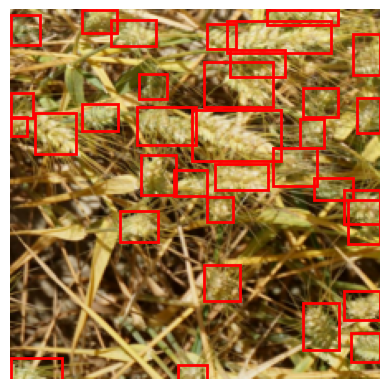

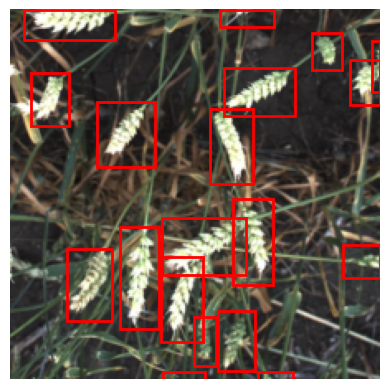

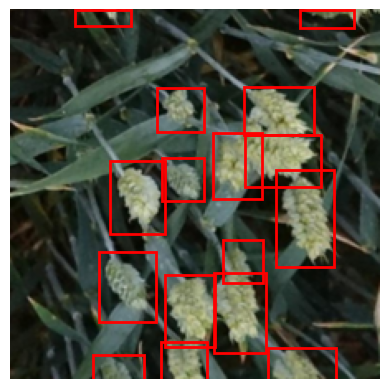

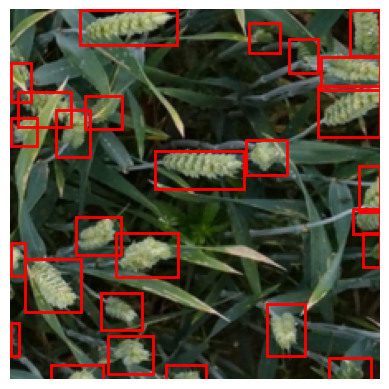

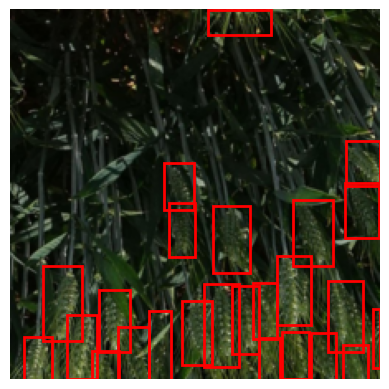

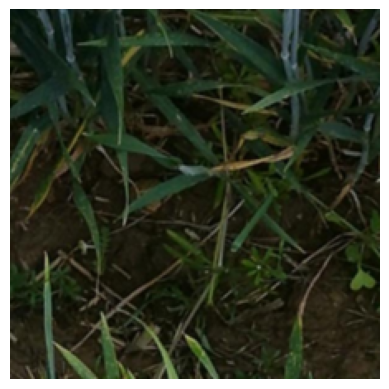

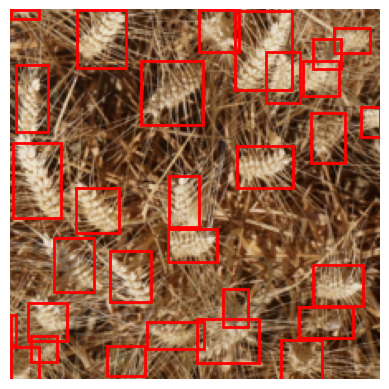

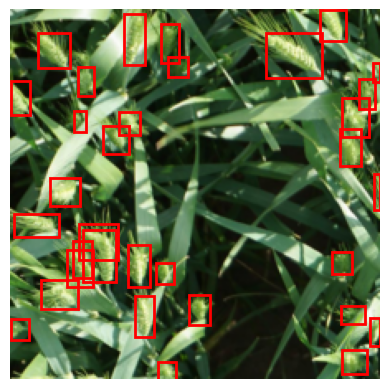

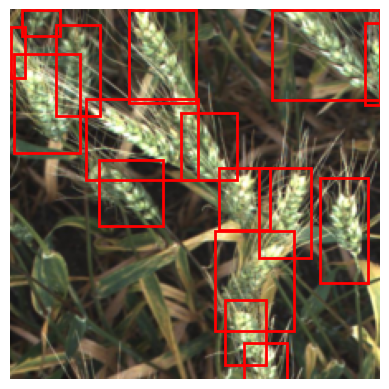

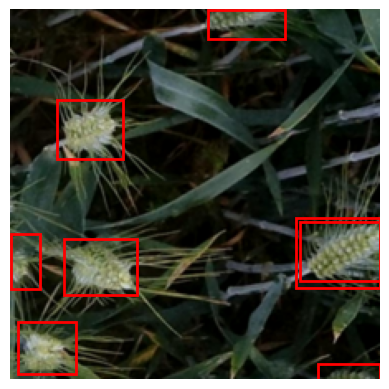

In [3]:
train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(0.5, format="XYWH"),
    Random90DegreeRotation(format="XYWH"),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    RandomBBoxCropAndResize(
        orig_size=1024, 
        max_crop=1024, 
        min_crop=512, 
        new_size=224, 
        p=1.0, 
        format="XYWH", 
        threshold=0.25
        ),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    #IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    #IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])

train_dataset = BoundingBoxDataset(
    "global_wheat_detection/train.csv",
    "global_wheat_detection/train",
    combined_transform=train_transform,
    bbox_format='XYWH'
)

for i in range(10):
    train_dataset.show(i, show_bboxes=True)

## Pytorch Lightning Data Module



In [ ]:
# if you haven't installed pytorch lightning yet, uncomment the following line
#!pip install lightning

In [ ]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split


class BoundingBoxDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, dataset_dir, split=0.9, batch_size=32, num_workers=4, train_transform=None, val_transform=None, bbox_format='xymin_xymax'):
        """
        Args:
            csv_file (str): Path to the CSV file for the training set.
            dataset_dir (str): Path to the directory containing image files.
            augmentations_dir (str): Path to the directory for storing augmented images.
            batch_size (int, optional): Number of samples per batch. Default is 32.
            num_workers (int, optional): Number of worker threads for data loading. Default is 4.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super().__init__()
        self.csv_file = csv_file
        self.dataset_dir = dataset_dir
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.val_transform = val_transform
        self.bbox_format = bbox_format

    def setup(self, stage=None):
        # Full dataset with 'val_transform' as a default
        full_dataset = BoundingBoxDataset(
            self.csv_file,
            self.dataset_dir,
            combined_transform=self.val_transform,
            bbox_format=self.bbox_format
        )

        # Split dataset (reproducible)
        train_size = int(len(full_dataset) * self.split)
        val_size = len(full_dataset) - train_size
        generator = torch.Generator().manual_seed(42)
        self.train_dataset, self.val_dataset = random_split(
            full_dataset,
            [train_size, val_size],
            generator=generator
        )

        # Overwrite transforms for each subset
        self.train_dataset.dataset.combined_transform = self.train_transform
        self.val_dataset.dataset.combined_transform = self.val_transform

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn
        )

    @staticmethod
    def collate_fn(batch):
        """
        Custom collate function for detection tasks.
        Each item in 'batch' is (image, target_dict).
        We just group images into a list and targets into another list.
        """
        images, targets = [], []
        for image, target in batch:
            images.append(image)
            targets.append(target)
        return images, targets

# Evaluation Metric

To handle the evaluation metric of the competition, we implemented a function for this. It is not the most efficient, so you should avoid reusing it. However, it is much quicker than the first tries we did because we are using tensor operations

In [5]:
import torch
import torchvision

def ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes,
                                   thresholds=[0.50, 0.55, 0.60, 0.65, 0.70, 0.75]):

    # Handle images without any target boxes
    if len(gt_boxes) == 0:
        # If no ground truth but also no predictions can treat as a perfect score
        if len(pred_boxes) == 0:
            return 1.0
        else:
            # No ground truth, but predictions exist => 0.0
            return 0.0

    # 1) Compute all pairwise IoUs: shape [num_preds, num_gts]
    iou_mat = torchvision.ops.box_iou(pred_boxes, gt_boxes)

    # 2) Sort predictions by descending confidence
    sorted_indices = torch.argsort(pred_scores, descending=True)
    iou_mat_sorted = iou_mat[sorted_indices]  # Reorder rows

    num_gt = gt_boxes.size(0)
    precs = []

    # 3) Loop over IoU thresholds
    for thr in thresholds:
        # Track which ground-truth boxes have been matched
        matched_gt = torch.zeros(num_gt, dtype=torch.bool, device=gt_boxes.device)

        tp = 0
        fp = 0

        # Iterate predicted boxes in descending score order
        for i in range(len(sorted_indices)):
            # iou_mat_sorted[i] is shape [num_gts]
            ious_this_pred = iou_mat_sorted[i]

            # "Ignore" ground truths that are already matched
            # We can set them to -1 so they won't be chosen
            ious_masked = ious_this_pred.clone()
            ious_masked[matched_gt] = -1.0

            best_iou, best_gt_idx = torch.max(ious_masked, dim=0)

            if best_iou >= thr:
                tp += 1
                matched_gt[best_gt_idx] = True
            else:
                fp += 1

        # Remaining unmatched ground truths => FN
        fn = num_gt - matched_gt.sum().item()

        denom = tp + fp + fn
        precision = float(tp) / float(denom) if denom > 0 else 0.0
        precs.append(precision)

    # 4) Return average precision across all thresholds
    return sum(precs) / len(precs)


# Faster RCNN

We have chosen to use faster rcnn for this competition.

In [11]:
import torch
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models import resnet50
from torchvision.ops import MultiScaleRoIAlign
import pytorch_lightning as pl

class FasterRCNNModel(pl.LightningModule):
    def __init__(self, num_classes=2, backbone_pretrained=True, weights_path=None, anchor_sizes: tuple = (16, 32, 64, 128, 256), aspect_ratios: tuple = (0.5, 1.0, 0.5)):
        """
        Faster R-CNN model for object detection.
        Args:
            num_classes (int): Number of object classes including the background class.
            backbone_pretrained (bool): Whether to use a pretrained ResNet backbone.
        """
        super().__init__()
        # Load a ResNet backbone
        backbone = resnet50(weights='IMAGENET1K_V2' if backbone_pretrained else None)
        # Remove the classification head to get feature extractor
        backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))
        if weights_path:
            state_dict = torch.load(weights_path)
            backbone.load_state_dict(state_dict, strict=False)

        backbone.out_channels = 2048  # ResNet-50 output channels for the last conv layer

        # Define RPN anchor generator
        anchor_generator = AnchorGenerator(
            sizes=(anchor_sizes,),   # Anchor sizes
            aspect_ratios=(aspect_ratios,)         # Aspect ratios
        )

        # Define ROI Pooler
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=["0"],  # Feature map names from the backbone
            output_size=7,
            sampling_ratio=2
        )

        # Initialize Faster R-CNN
        self.model = FasterRCNN(
            backbone,
            num_classes=num_classes,  # Includes background class
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler
        )

        self.all_outputs = []  # Used to store batch results for validation_epoch_end
        self.save_hyperparameters()

    def freeze_backbone(self, ratio):
        """
        Freezes the first layers of the backbone. 
        
        Args: 
            ratio: The faction of parameters, that are being frozen e.g. 0.6 -> first 60% of params are being frozen. Can be used to unfreeze by 0.0
        """
        # First unfreeze all parameters
        for param in self.model.backbone.parameters():
            param.requires_grad = True
            
        if ratio == 0.0:
            return
            
        # Count total layers in backbone
        total_layers = 0
        layers_list = []
        for module in self.model.backbone.modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.BatchNorm2d)):
                total_layers += 1
                layers_list.append(module)
                
        # Calculate how many layers to freeze
        num_layers_to_freeze = int(total_layers * ratio)
        
        # Freeze the first num_layers_to_freeze layers
        for i, module in enumerate(layers_list):
            if i < num_layers_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False


    def forward(self, images, targets=None):
        """
        Forward pass through Faster R-CNN.
        Args:
            images (list[Tensor]): List of images.
            targets (list[Dict]): List of targets (optional during inference).
        Returns:
            Model outputs during inference or loss during training.
        """
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        """
        Training step for Faster R-CNN.
        Args:
            batch (tuple): Batch containing images and targets.
            batch_idx (int): Batch index.
        Returns:
            torch.Tensor: Total loss for the batch.
        """
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]

        outputs = self.model(images)

        # Store outputs for epoch-level aggregation
        self.all_outputs.append({"preds": outputs, "targets": targets})
        return {"preds": outputs, "targets": targets}

    def on_validation_epoch_end(self):
        """Compute mAP at the end of each validation epoch."""
        all_aps = []

        for batch_out in self.all_outputs:
            preds = batch_out["preds"]
            targets = batch_out["targets"]
            
            for i in range(len(preds)):
                pred_boxes  = preds[i]["boxes"]
                pred_scores = preds[i]["scores"]
                gt_boxes    = targets[i]["boxes"]

                # Compute AP for this image
                ap_val = ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes)
                all_aps.append(ap_val)

        mean_ap = sum(all_aps) / len(all_aps) if len(all_aps) > 0 else 0.0

        self.log("val_mAP", mean_ap, prog_bar=True)

        # Clear stored outputs to avoid memory issues
        self.all_outputs.clear()

    def configure_optimizers(self):
        """
        Define optimizer and learning rate scheduler.
        Returns:
            tuple: Optimizer and LR scheduler.
        """
        
        # Split parameters into backbone and rest of the model
        backbone_params = []
        other_params = []
        for name, param in self.model.named_parameters():
            if "backbone" in name:
                backbone_params.append(param)
            else:
                other_params.append(param)

        # Create parameter groups with different learning rates
        param_groups = [
            {'params': backbone_params, 'lr': 0.0001},  # Lower LR for backbone
            {'params': other_params, 'lr': 0.001}  # Higher LR for other parts
        ]
        
        optimizer = torch.optim.AdamW(param_groups, weight_decay=0.0001)

        # Learning rate scheduler with warmup
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[0.0005, 0.005],  # Max LR for each parameter group
            total_steps=self.trainer.estimated_stepping_batches,
            pct_start=0.05,         # Warmup phase is 10% of training
            div_factor=10,          # Initial LR is max_lr/10
            final_div_factor=100,   # Final LR is max_lr/1000
        )

        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

### Simulating the Learning Rate Scheduler

We are using a learning rate scheduler. To avoid missconfigurations, we are using a function to plot the learning rate from our parameters.

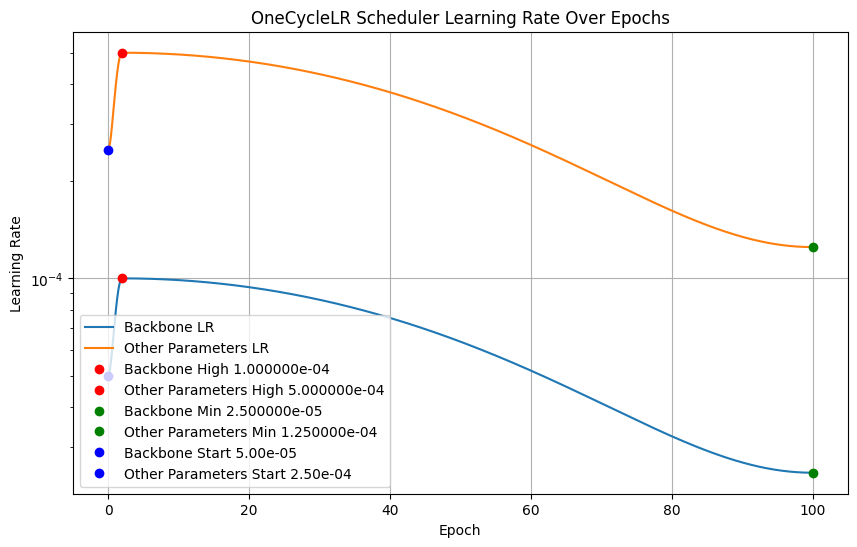

In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import OneCycleLR

def simulate_one_cycle_lr(
    num_epochs=10,
    steps_per_epoch=100,
    max_lr=[0.0005, 0.005],
    pct_start=0.05,
    div_factor=10,
    final_div_factor=100
):
    """
    Simulate and plot the OneCycleLR learning rate schedule for two parameter groups.
    
    Args:
        num_epochs (int): Number of epochs to simulate.
        steps_per_epoch (int): Number of optimizer steps per epoch.
        max_lr (list of float): Maximum learning rates for each parameter group.
        pct_start (float): Percentage of the cycle spent increasing the LR.
        div_factor (float): Initial LR is max_lr/div_factor.
        final_div_factor (float): Final LR is max_lr/final_div_factor.
    
    This function plots the learning rate changes over epochs.
    """
    total_steps = num_epochs * steps_per_epoch

    # Create two distinct dummy parameter groups (each with its own parameter)
    dummy_param_group0 = [torch.nn.Parameter(torch.zeros(1))]
    dummy_param_group1 = [torch.nn.Parameter(torch.zeros(1))]

    # Create a dummy optimizer with two parameter groups. Set starting LR as max_lr/div_factor.
    optimizer = torch.optim.AdamW([
        {'params': dummy_param_group0, 'lr': max_lr[0] / div_factor},
        {'params': dummy_param_group1, 'lr': max_lr[1] / div_factor}
    ])

    # Instantiate the OneCycleLR scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        total_steps=total_steps,
        pct_start=pct_start,
        div_factor=div_factor,
        final_div_factor=final_div_factor,
        anneal_strategy="cos"
    )

    # Record the learning rates for each parameter group at every step
    lr_history_group0 = []
    lr_history_group1 = []

    for step in range(total_steps):
        # Record current LRs before stepping the scheduler
        lr_history_group0.append(optimizer.param_groups[0]["lr"])
        lr_history_group1.append(optimizer.param_groups[1]["lr"])
        scheduler.step()

    # Convert steps to epochs for plotting
    steps = np.arange(total_steps)
    epochs = steps / steps_per_epoch

    # mark high point for all parameter groups
    group0_high = max(lr_history_group0)
    group0_high_epoch = lr_history_group0.index(group0_high) // steps_per_epoch + 1
    group1_high = max(lr_history_group1)
    group1_high_epoch = lr_history_group1.index(group1_high) // steps_per_epoch + 1

    group0_min = min(lr_history_group0)
    group0_min_epoch = lr_history_group0.index(group0_min) // steps_per_epoch + 1
    group1_min = min(lr_history_group1)
    group1_min_epoch = lr_history_group1.index(group1_min) // steps_per_epoch + 1

    start_lr0 = lr_history_group0[0]
    start_lr1 = lr_history_group1[0]


    # Plotting the learning rate schedule for both groups
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, lr_history_group0, label="Backbone LR")
    plt.plot(epochs, lr_history_group1, label="Other Parameters LR")
    # plot high points
    plt.plot(group0_high_epoch, group0_high, 'ro', label=f"Backbone High {group0_high:2e}")
    plt.plot(group1_high_epoch, group1_high, 'ro', label=f"Other Parameters High {group1_high:2e}")
    # plot low points
    plt.plot(group0_min_epoch, group0_min, 'go', label=f"Backbone Min {group0_min:2e}")
    plt.plot(group1_min_epoch, group1_min, 'go', label=f"Other Parameters Min {group1_min:2e}")
    # plot start points
    plt.plot(0, start_lr0, 'bo', label=f"Backbone Start {start_lr0:.2e}")
    plt.plot(0, start_lr1, 'bo', label=f"Other Parameters Start {start_lr1:.2e}")

    # y-axis in log scale for better visualization
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("OneCycleLR Scheduler Learning Rate Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
simulate_one_cycle_lr(
    num_epochs=100,
    steps_per_epoch=100,
    max_lr=[0.0001, 0.0005],
    pct_start=0.02,
    div_factor=2,
    final_div_factor=2
)

##  Training the First Version of Faster RCNN

In [52]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
torch.set_float32_matmul_precision('medium')


train_transform = v2.Compose([
    Random90DegreeRotation(),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    ResizeBBox(new_size=224),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=2,
    num_workers=4,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform
)


# Initialize Model
model = FasterRCNNModel(
    num_classes=2,
    backbone_pretrained=True,
    anchor_sizes=(16, 32, 64, 128),
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0)
    )

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_2",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=3,
    mode="max"
)

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 165 M  | train
---------------------------------------------
165 M     Trainable params
0         Non-trainable params
165 M     Total params
661.140   Total estimated model params size (MB)
168       Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 1540/1540 [08:52<00:00,  2.89it/s, v_num=11, train_loss_step=0.0143, val_mAP=0.461, train_loss_epoch=0.400]


<Axes: xlabel='epoch'>

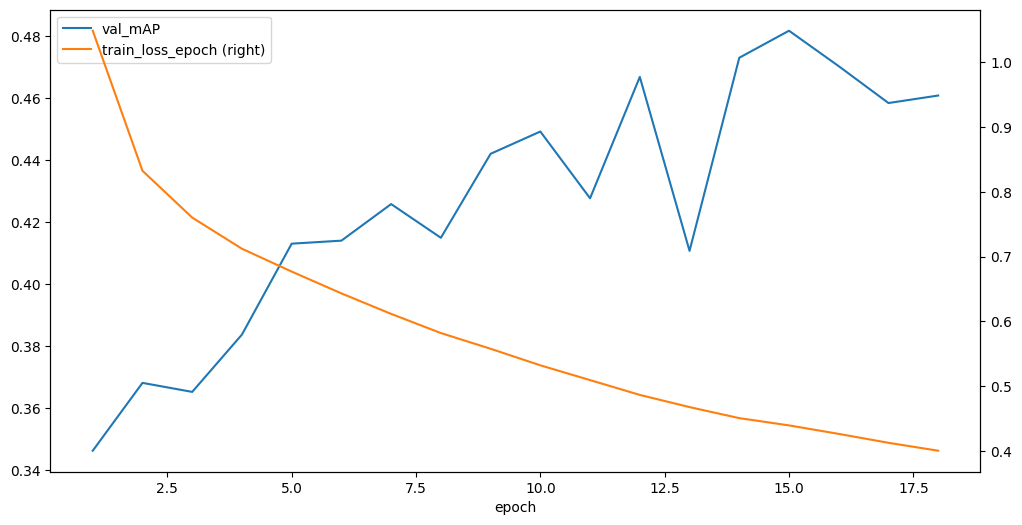

In [13]:
log_path = "logs/fasterrcnn/version_11/metrics.csv"

# Load the metrics CSV file
metrics_df = pd.read_csv(log_path)
val_ap_df = metrics_df[["epoch", "val_mAP"]]
val_ap_df = val_ap_df.dropna()
train_loss_df = metrics_df[["epoch", "train_loss_epoch"]]
train_loss_df = train_loss_df.dropna()
# merge the dataframes at epoch
merged_df = pd.merge(val_ap_df, train_loss_df, on="epoch")

# Plot the validation mAP and training loss in a single plot
merged_df['epoch'] = merged_df['epoch'] + 1

merged_df.plot(x="epoch", y=["val_mAP", "train_loss_epoch"], secondary_y="train_loss_epoch", figsize=(12, 6))

In [9]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
torch.set_float32_matmul_precision('medium')


train_transform = v2.Compose([
    #v2.RandomHorizontalFlip(p=0.5),
    Random90DegreeRotation(),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    ResizeBBox(new_size=224),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=2,
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform
)


# Initialize Model
model = FasterRCNNModel(
    num_classes=2,
    backbone_pretrained=True,
    anchor_sizes=(16, 32, 64, 128),
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0)
    )

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_2",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=5,         # 3 was too low
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 165 M  | train
---------------------------------------------
165 M     Trainable params
0         Non-trainable params
165 M     Total params
661.140   Total estimated model params size (MB)
168       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/1540 [00:00<?, ?it/s]                          

/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 28: 100%|██████████| 1540/1540 [08:33<00:00,  3.00it/s, v_num=13, train_loss_step=0.445, val_mAP=0.497, train_loss_epoch=0.318] 


In [20]:
# Get best model path from checkpoint callback
best_model_path = checkpoint_callback.best_model_path

# Load the best model
best_model = FasterRCNNModel.load_from_checkpoint(best_model_path)

# Save just the state dict
torch.save(model.state_dict(), "wheat_detection_model_resnet50_no_pretraining_low_augmentation.pth")
print(f"Best model saved from checkpoint: {best_model_path}")

Best model saved from checkpoint: /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints_2/fasterrcnn-epoch=23-valmAp=0.00.ckpt


           epoch    val_mAP  train_loss_epoch   lr-AdamW
count  28.000000  28.000000         28.000000  28.000000
mean   13.500000   0.453933          0.501514   0.000223
std     8.225975   0.052004          0.175209   0.000013
min     0.000000   0.316126          0.323485   0.000202
25%     6.750000   0.428131          0.368608   0.000212
50%    13.500000   0.463425          0.442539   0.000223
75%    20.250000   0.500642          0.587154   0.000233
max    27.000000   0.514453          1.041747   0.000244


<Axes: xlabel='epoch'>

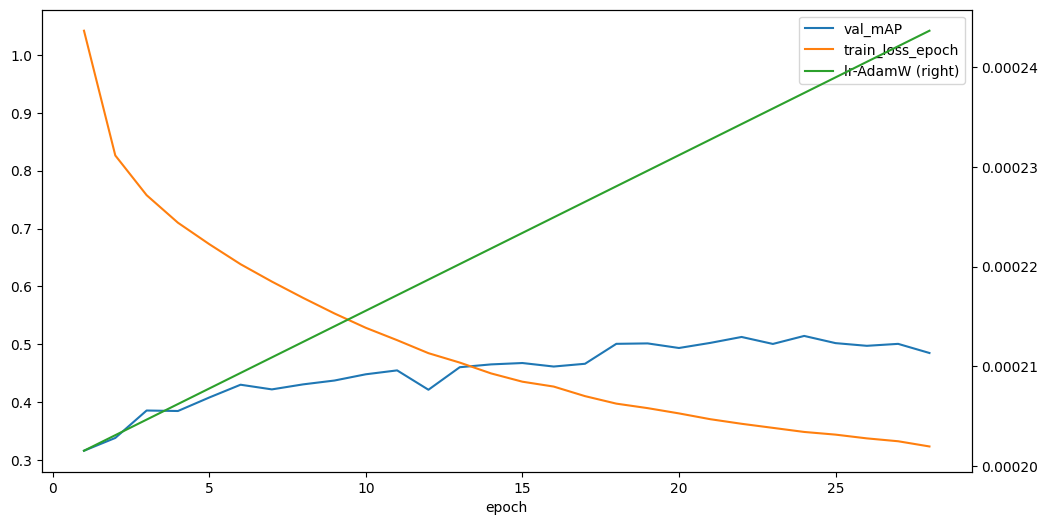

In [24]:
log_path = "logs/fasterrcnn/version_13/metrics.csv"

# Load the metrics CSV file
metrics_df = pd.read_csv(log_path)
# backward fill the epoch
metrics_df["epoch"] = metrics_df["epoch"].bfill()
metrics_df["lr-AdamW"] = metrics_df["lr-AdamW"].bfill()

val_ap_df = metrics_df[["epoch", "val_mAP"]]
val_ap_df = val_ap_df.dropna()
train_loss_df = metrics_df[["epoch", "train_loss_epoch", "lr-AdamW"]]
train_loss_df = train_loss_df.dropna()
# merge the dataframes at epoch
merged_df = pd.merge(val_ap_df, train_loss_df, on="epoch")
print(merged_df.describe())
# Plot the validation mAP and training loss in a single plot
merged_df['epoch'] = merged_df['epoch'] + 1

merged_df.plot(x="epoch", y=["val_mAP", "train_loss_epoch", "lr-AdamW"], secondary_y="lr-AdamW", figsize=(12, 6))

In [51]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
torch.set_float32_matmul_precision('medium')


train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(0.5, format="XYWH"),
    Random90DegreeRotation(format="XYWH"),
    RandomRGBGradient(min_intensity=-0.1, max_intensity=0.1, mode="RGB", p=0.5),
    ResizeBBox(new_size=224),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=4,
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform
)


# Initialize Model
model = FasterRCNNModel(
    num_classes=2,
    backbone_pretrained=True,
    weights_path="resnet50_plantnet.pth",
    anchor_sizes=(16, 32, 64),
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0)
    )

# freeze first 60% of backbone
model.freeze_backbone(0.6)

In [52]:
# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_3",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=10,         # 3 was too low
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 165 M  | train
---------------------------------------------
160 M     Trainable params
4.3 M     Non-trainable params
165 M     Total params
660.935   Total estimated model params size (MB)
168       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/770 [00:00<?, ?it/s]                           

/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 99: 100%|██████████| 770/770 [06:06<00:00,  2.10it/s, v_num=14, train_loss_step=0.173, val_mAP=0.533, train_loss_epoch=0.165] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 770/770 [06:06<00:00,  2.10it/s, v_num=14, train_loss_step=0.173, val_mAP=0.533, train_loss_epoch=0.165]


In [53]:
# 🔹 Save Pretrained Backbone (without classification head)
torch.save(model.state_dict(), "global_wheat_pred_100e_60frozen.pth")

In [54]:
model.freeze_backbone(0.0)

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

torch.save(model.state_dict(), "global_wheat_pred_200e_0frozen.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 165 M  | train
---------------------------------------------
165 M     Trainable params
0         Non-trainable params
165 M     Total params
660.935   Total estimated model params size (MB)
168       Modules in train mode
0         Modules in eval mode


Epoch 6: 100%|██████████| 770/770 [07:45<00:00,  1.66it/s, v_num=14, train_loss_step=0.639, val_mAP=0.372, train_loss_epoch=0.569]


## Second Version of the Faster RCNN Model

Learning from the experience of the first model, we wrote a new version of the lightning module. We could just have changed the old version, but this would make it hard to load the weighs from the state dict again.

In [ ]:
class FasterRCNNModel_V2(pl.LightningModule):
    def __init__(self, num_classes=2, backbone_pretrained=True, weights_path=None):
        """
        Faster R-CNN model for object detection.
        Adjusted for images resized to (224, 224) and objects mostly between 11 and 33 pixels.
        """
        super().__init__()
        # Load a ResNet backbone and remove classification head
        backbone = resnet50(weights='IMAGENET1K_V2' if backbone_pretrained else None)
        backbone = torch.nn.Sequential(*(list(backbone.children())[:-2]))   # Remove classification head
        if weights_path:
            state_dict = torch.load(weights_path)
            backbone.load_state_dict(state_dict, strict=False)
        backbone.out_channels = 2048
        self.save_hyperparameters()

        # --- 1. Anchor Generator ---
        # Using sizes that roughly cover 11 to 33 pixels (after resize) and aspect ratios based on the distribution.
        anchor_sizes = (12, 24, 36)  # scales chosen for the resized images
        aspect_ratios = (0.5, 1.0, 1.5)
        anchor_generator = AnchorGenerator(
            sizes=(anchor_sizes,),         # for the single feature map level
            aspect_ratios=(aspect_ratios,)
        )

        # --- 3. ROI Pooler ---
        # Increase sampling_ratio to get finer features for small objects.
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=["0"], 
            output_size=7,
            sampling_ratio=4  # increased from 2
        )

        # --- 2. RPN and Faster R-CNN initialization ---
        # Adjust RPN proposal counts and thresholds for small, crowded objects.
        self.model = FasterRCNN(
            backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            # Increase the number of proposals (pre and post NMS)
            rpn_pre_nms_top_n_train=3000,
            rpn_post_nms_top_n_train=1500,
            rpn_pre_nms_top_n_test=3000,
            rpn_post_nms_top_n_test=1500,
            # Adjust NMS threshold to allow more overlap in crowded scenes
            rpn_nms_thresh=0.8,
            # Lower the IoU threshold for positive anchors (small objects may get lower IoU)
            rpn_fg_iou_thresh=0.6,
            # Slightly raise the IoU threshold for negatives to reduce ambiguity
            rpn_bg_iou_thresh=0.4
        )

        self.all_outputs = []  # For storing outputs during validation

    # (The rest of the model code remains unchanged.)
    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images)
        self.all_outputs.append({"preds": outputs, "targets": targets})
        return {"preds": outputs, "targets": targets}

    def on_validation_epoch_end(self):
        all_aps = []
        for batch_out in self.all_outputs:
            preds = batch_out["preds"]
            targets = batch_out["targets"]
            for i in range(len(preds)):
                pred_boxes  = preds[i]["boxes"]
                pred_scores = preds[i]["scores"]
                gt_boxes    = targets[i]["boxes"]
                ap_val = ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes)
                all_aps.append(ap_val)
        mean_ap = sum(all_aps) / len(all_aps) if all_aps else 0.0
        self.log("val_mAP", mean_ap, prog_bar=True)
        self.all_outputs.clear()

    def freeze_backbone(self, ratio):
        """
        Freezes the first layers of the backbone. 
        
        Args: 
            ratio: The faction of parameters, that are being frozen e.g. 0.6 -> first 60% of params are being frozen. Can be used to unfreeze by 0.0
        """
        # First unfreeze all parameters
        for param in self.model.backbone.parameters():
            param.requires_grad = True
            
        if ratio == 0.0:
            return
            
        # Count total layers in backbone
        total_layers = 0
        layers_list = []
        for module in self.model.backbone.modules():
            if isinstance(module, (torch.nn.Conv2d, torch.nn.BatchNorm2d)):
                total_layers += 1
                layers_list.append(module)
                
        # Calculate how many layers to freeze
        num_layers_to_freeze = int(total_layers * ratio)
        
        # Freeze the first num_layers_to_freeze layers
        for i, module in enumerate(layers_list):
            if i < num_layers_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
        
    def configure_optimizers(self):
        # Optimizer and scheduler configuration

        # find maximum total steps based on the number of epochs from the trainer (epochs) and the length of the train_dataloader from the data module
        max_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())

        backbone_params = []
        other_params = []
        for name, param in self.model.named_parameters():
            if "backbone" in name:
                backbone_params.append(param)
            else:
                other_params.append(param)
        param_groups = [
            {'params': backbone_params, 'lr': 0.0001},
            {'params': other_params, 'lr': 0.0001}
        ]
        optimizer = torch.optim.Adam(param_groups)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[0.0001, 0.0001],
            total_steps=max_steps,
            pct_start=0.02,
            div_factor=2,
            final_div_factor=2,
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

In [14]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

torch.set_float32_matmul_precision('medium')


train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(0.5, format="XYXY"),   # 50% chance of horizontal flip
    Random90DegreeRotation(format="XYXY"),          # Random 90 degree rotation (25% chance for each orientation)
    RandomBBoxCropAndResize(
        orig_size=1024,     # Crop from 1024x1024 images
        max_crop=1024,      # Crop between 512 and 1024 pixels
        min_crop=512,       
        new_size=224,       # Resize to 224x224 for ResNet-50 Backbone
        p=0.5,              # 50% chance to apply the crop (resize is applied regardless). This is to avoid training the model on too big objects
        format="XYXY",
        threshold=0.25      # 25% of the object must be in the crop for the box to be included
    ),
    # normalize to ImageNet mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=4,
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform,
    bbox_format='xymin_xymax'       # Use XYXY format for bounding boxes
)


# Initialize Model
model = FasterRCNNModel_V2(
    num_classes=2,
    backbone_pretrained=False,
    weights_path="resnet50_plantnet_best.pth"
    )

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_4",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=10,         # 3 was too low
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

# load best checkpoint
# After training is complete, retrieve the best checkpoint path.
best_checkpoint_path = checkpoint_callback.best_model_path

# Load the best model from checkpoint.
# Note: If your __init__ requires additional arguments that aren't saved in hyperparameters,
model = FasterRCNNModel_V2.load_from_checkpoint(best_checkpoint_path)

# Save the backbone's state dict to a .pth file.
torch.save(model.state_dict(), "faster_fcnn_v2.pth")
print("Weights have been saved to faster_fcnn_v2.pth")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/cateagle/Code/GlobalWheatDetection-1/Training/checkpoints_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 165 M  | train
---------------------------------------------
165 M     Trainable params
0         Non-trainable params
165 M     Total params
660.689   Total estimated model params size (MB)
168       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/770 [00:00<?, ?it/s]                           

/home/cateagle/Code/GlobalWheatDetection-1/.venv/lib/python3.12/site-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 3. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 66: 100%|██████████| 770/770 [12:16<00:00,  1.05it/s, v_num=20, train_loss_step=0.277, val_mAP=0.480, train_loss_epoch=0.252] 


MisconfigurationException: No `test_step()` method defined to run `Trainer.test`.

Here the code ran into an error because I forgot to include a test_step() method in the lightning module. As this was just on the last step after the training, We could just continue with the model.

           epoch    val_mAP  train_loss_epoch  lr-Adam/pg1  lr-Adam/pg2
count  66.000000  66.000000         66.000000    66.000000    66.000000
mean   32.500000   0.390181          0.653154     0.000079     0.000079
std    19.196354   0.090725          0.371351     0.000018     0.000018
min     0.000000   0.119544          0.252881     0.000045     0.000045
25%    16.250000   0.330175          0.348880     0.000064     0.000064
50%    32.500000   0.427711          0.526997     0.000081     0.000081
75%    48.750000   0.458917          0.899546     0.000095     0.000095
max    65.000000   0.493499          1.752638     0.000100     0.000100


<Axes: xlabel='epoch'>

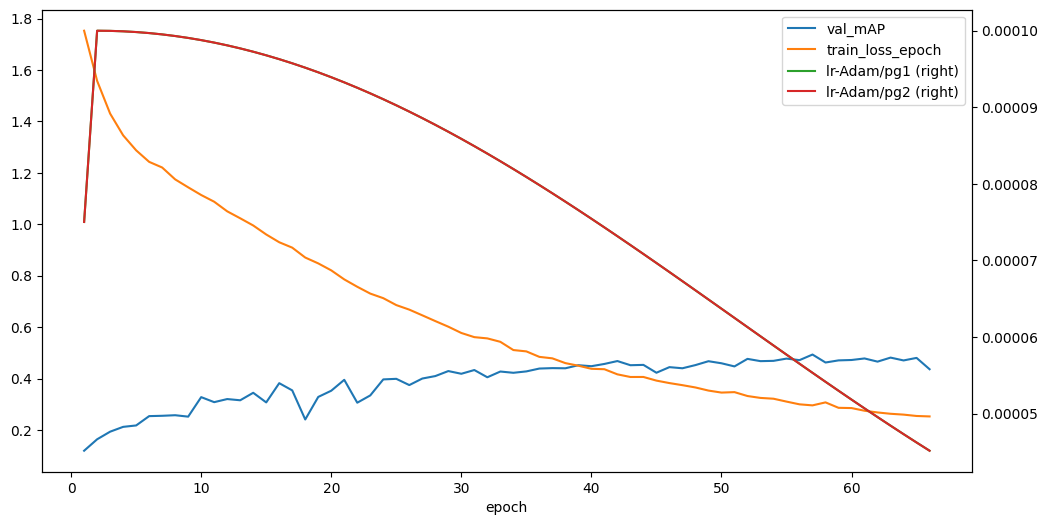

In [17]:
log_path = "logs/fasterrcnn/version_20/metrics.csv"

# Load the metrics CSV file
metrics_df = pd.read_csv(log_path)
# backward fill the epoch
metrics_df["epoch"] = metrics_df["epoch"].bfill()
metrics_df["lr-Adam/pg1"] = metrics_df["lr-Adam/pg1"].bfill()
metrics_df["lr-Adam/pg2"] = metrics_df["lr-Adam/pg2"].bfill()

val_ap_df = metrics_df[["epoch", "val_mAP"]]
val_ap_df = val_ap_df.dropna()
train_loss_df = metrics_df[["epoch", "train_loss_epoch", "lr-Adam/pg1", "lr-Adam/pg2"]]
train_loss_df = train_loss_df.dropna()
# merge the dataframes at epoch
merged_df = pd.merge(val_ap_df, train_loss_df, on="epoch")
print(merged_df.describe())
# Plot the validation mAP and training loss in a single plot
merged_df['epoch'] = merged_df['epoch'] + 1

merged_df.plot(x="epoch", y=["val_mAP", "train_loss_epoch", "lr-Adam/pg1", "lr-Adam/pg2"], secondary_y=["lr-Adam/pg1", "lr-Adam/pg2"], figsize=(12, 6))

in case you are wondering about the learning rate of parameter group 1, it is identical to group 2, so group two was rendered in front of it.

## Transformer Backbone Faster RCNN

The resnet backbone model seemed to hit a plateau at 0.5, so we wanted to try a different backbone. We chose a ViT backbone model, that has been trained on the plantnet-300k dataset. We hoped that the model will be able to transfer it's experience from other plants to the competition task.

In [ ]:
# if not already installed, install the transformers library
#!pip install transformers

In [9]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from transformers import ViTModel

# --- Custom ViT Backbone Wrapper ---
class ViTBackbone(nn.Module):
    def __init__(self, model_name='janjibDEV/vit-plantnet300k'):
        """
        Wraps a ViT model so that it can serve as a backbone for Faster R-CNN.
        It extracts patch embeddings and reshapes them into a spatial feature map.
        """
        super().__init__()
        # Load the pretrained ViT model
        self.vit = ViTModel.from_pretrained(model_name)
        # The hidden size of the ViT is used as the number of output channels.
        self.out_channels = self.vit.config.hidden_size

        # Retrieve expected image and patch sizes from the model configuration.
        self.image_size = self.vit.config.image_size if hasattr(self.vit.config, 'image_size') else 224
        self.patch_size = self.vit.config.patch_size if hasattr(self.vit.config, 'patch_size') else 16

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, channels, H, W)
        Returns:
            A dict mapping a feature map name (here "0") to a feature map tensor.
            The feature map is obtained by:
              - Running the image through the ViT,
              - Removing the [CLS] token,
              - Reshaping the remaining tokens into a 2D grid.
        """
        # Enable positional encoding interpolation to handle inputs with different sizes.
        outputs = self.vit(x, interpolate_pos_encoding=True)
        # outputs.last_hidden_state shape: (batch_size, 1 + num_patches, hidden_size)
        # Discard the [CLS] token (first token)
        patch_tokens = outputs.last_hidden_state[:, 1:, :]  # (batch_size, num_patches, hidden_size)

        # Calculate grid size: assumes the number of patches forms a perfect square.
        grid_size = int(patch_tokens.shape[1] ** 0.5)
        if grid_size * grid_size != patch_tokens.shape[1]:
            raise ValueError("The number of patches is not a perfect square. Check your image and patch sizes.")

        # Reshape the tokens to a 2D feature map.
        feature_map = patch_tokens.transpose(1, 2).reshape(x.size(0), self.out_channels, grid_size, grid_size)
        return {"0": feature_map}

# --- Modified Lightning Module using the ViT Backbone ---
class FasterRCNNModel_ViT(pl.LightningModule):
    def __init__(self, num_classes=2, backbone_path='janjibDEV/vit-plantnet300k', aspect_ratios=(0.5, 1.0, 1.5), anchor_sizes=(12, 24, 36), roi_sampling_ratio=4, roi_output_size=7, base_lr_backbone=0.0001, base_lr_other=0.0001):
        """
        Faster R-CNN model for object detection.
        Option to use a transformer backbone.
        """
        super().__init__()

        # Use the transformer backbone from Hugging Face.
        backbone = ViTBackbone(model_name=backbone_path)
        self.base_lr_backbone = base_lr_backbone
        self.base_lr_other = base_lr_other

        self.save_hyperparameters()

        # --- Anchor Generator ---
        anchor_generator = AnchorGenerator(
            sizes=(anchor_sizes,),         # Single feature map level
            aspect_ratios=(aspect_ratios,)
        )

        # --- ROI Pooler ---
        roi_pooler = MultiScaleRoIAlign(
            featmap_names=["0"], 
            output_size=roi_output_size,
            sampling_ratio=roi_sampling_ratio  # Increased sampling ratio for small objects.
        )

        # --- RPN and Faster R-CNN initialization ---
        self.model = FasterRCNN(
            backbone,
            num_classes=num_classes,
            rpn_anchor_generator=anchor_generator,
            box_roi_pool=roi_pooler,
            rpn_pre_nms_top_n_train=3000,
            rpn_post_nms_top_n_train=1500,
            rpn_pre_nms_top_n_test=3000,
            rpn_post_nms_top_n_test=1500,
            rpn_nms_thresh=0.8,
            rpn_fg_iou_thresh=0.6,
            rpn_bg_iou_thresh=0.4
        )

        self.all_outputs = []  # For storing outputs during validation

    def forward(self, images, targets=None):
        return self.model(images, targets)

    def training_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        images = list(image for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images)
        self.all_outputs.append({"preds": outputs, "targets": targets})
        return {"preds": outputs, "targets": targets}

    def on_validation_epoch_end(self):
        all_aps = []
        for batch_out in self.all_outputs:
            preds = batch_out["preds"]
            targets = batch_out["targets"]
            for i in range(len(preds)):
                pred_boxes  = preds[i]["boxes"]
                pred_scores = preds[i]["scores"]
                gt_boxes    = targets[i]["boxes"]
                # Ensure that you have defined ap_one_image_across_thresholds.
                ap_val = ap_one_image_across_thresholds(pred_boxes, pred_scores, gt_boxes)
                all_aps.append(ap_val)
        mean_ap = sum(all_aps) / len(all_aps) if all_aps else 0.0
        self.log("val_mAP", mean_ap, prog_bar=True)
        self.all_outputs.clear()

    def freeze_backbone(self, ratio):
        """
        Freezes the first layers of the backbone. 
        Args: 
            ratio: The fraction of parameters to freeze, e.g. 0.6 -> freeze first 60% of params.
        """
        # Unfreeze all parameters first.
        for param in self.model.backbone.parameters():
            param.requires_grad = True
            
        if ratio == 0.0:
            return
            
        # Count layers in the backbone.
        total_layers = 0
        layers_list = []
        for module in self.model.backbone.modules():
            if isinstance(module, (nn.Conv2d, nn.BatchNorm2d)):
                total_layers += 1
                layers_list.append(module)
                
        num_layers_to_freeze = int(total_layers * ratio)
        
        for i, module in enumerate(layers_list):
            if i < num_layers_to_freeze:
                for param in module.parameters():
                    param.requires_grad = False
        
    def configure_optimizers(self):
        # Determine max steps based on trainer and dataloader.
        max_steps = self.trainer.max_epochs * len(self.trainer.datamodule.train_dataloader())

        backbone_params = []
        other_params = []
        for name, param in self.model.named_parameters():
            if "backbone" in name:
                backbone_params.append(param)
            else:
                other_params.append(param)
        param_groups = [
            {'params': backbone_params, 'lr': self.base_lr_backbone},
            {'params': other_params, 'lr': self.base_lr_other}
        ]
        optimizer = torch.optim.AdamW(param_groups, weight_decay=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[self.base_lr_backbone, self.base_lr_other],
            total_steps=max_steps,
            pct_start=0.02,
            div_factor=2,
            final_div_factor=2,
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

In [32]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

torch.set_float32_matmul_precision('medium')

train_transform = v2.Compose([
    RandomHorizontalBBoxFlip(0.5, format="XYXY"),   # 50% chance of horizontal flip
    Random90DegreeRotation(format="XYXY"),          # Random 90 degree rotation (25% chance for each orientation)
    RandomBBoxCropAndResize(
        orig_size=1024,     # Crop from 1024x1024 images
        max_crop=1024,      # Crop between 512 and 1024 pixels
        min_crop=512,       
        new_size=224,       # Resize to 224x224 for ResNet-50 Backbone
        p=0.5,              # 50% chance to apply the crop (resize is applied regardless). This is to avoid training the model on too big objects
        format="XYXY",
        threshold=0.25      # 25% of the object must be in the crop for the box to be included
    ),
    # normalize to 'google/vit-base-patch16-224' mean and std with a wrapper to ignore bounding boxes
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]))
])

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=2,   # lower batch size for ViT backbone
    num_workers=8,  # 2 seems to be optimal for colab
    train_transform=train_transform,
    val_transform=val_transform,
    bbox_format='xymin_xymax'       # Use XYXY format for bounding boxes
)


# Initialize Model
model = FasterRCNNModel_ViT(
    num_classes=2,
    backbone_path='janjibDEV/vit-plantnet300k', # backbone from Hugging Face trained on the plantnet dataset
    base_lr_backbone=0.0001,                    # slightly lower learning rate for backbone
    base_lr_other=0.0005,
    anchor_sizes=(12, 24, 32),                  # after resizing to 224x224, these are the most common sizes of wheat heads
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0),   # most common aspect ratios (5 gave better results than 3)
    roi_sampling_ratio=4,
    roi_output_size=7
    )


# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_mAP",
    dirpath="checkpoints_vit",
    filename="fasterrcnn-{epoch:02d}-{valmAp:.2f}",
    save_top_k=1,
    mode="max"
)

csv_logger = CSVLogger("logs", name="fasterrcnn")

early_stopping = EarlyStopping(
    monitor="val_mAP",
    patience=10,         # 3 was too low
    mode="max"
)

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

# Trainer
trainer = Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stopping, lr_monitor],
    logger=csv_logger
)

# Train Model
trainer.fit(model, datamodule=data_module)

# load best checkpoint
# After training is complete, retrieve the best checkpoint path.
best_checkpoint_path = checkpoint_callback.best_model_path

# Load the best model from checkpoint.
model = FasterRCNNModel_ViT.load_from_checkpoint(best_checkpoint_path)

# Save the models state dict to a ".pth" file.
torch.save(model.state_dict(), "faster_rcnn_vit.pth")
print("Weights have been saved to faster_fcnn_vit.pth") # make sure to include a typo in the filename to show that it was written by a human

Some weights of ViTModel were not initialized from the model checkpoint at janjibDEV/vit-plantnet300k and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | FasterRCNN | 131 M  | train
---------------------------------------------
131 M     Trainable params
0         Non-trainable params
131 M     Total params
525.409   Total estimated model params size (MB)
20        Modules in train mode
227       Modules in eval mode


Epoch 59: 100%|██████████| 1540/1540 [18:47<00:00,  1.37it/s, v_num=25, train_loss_step=0.0848, val_mAP=0.618, train_loss_epoch=0.119] 


Some weights of ViTModel were not initialized from the model checkpoint at janjibDEV/vit-plantnet300k and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Weights have been saved to faster_fcnn_vit.pth


In [ ]:
model = FasterRCNNModel_ViT(
    num_classes=2,
    backbone_path='janjibDEV/vit-plantnet300k', # backbone will be overwritten by state dict
    base_lr_backbone=0.0001,                    # slightly lower learning rate for backbone
    base_lr_other=0.0005,
    anchor_sizes=(12, 24, 32),                  # after resizing to 224x224, these are the most common sizes of wheat heads
    aspect_ratios=(0.5, 0.67, 1.0, 1.5, 2.0),   # most common aspect ratios (5 gave better results than 3)
    roi_sampling_ratio=4,
    roi_output_size=7
    )

model.load_state_dict(torch.load("faster_rcnn_vit.pth"))

val_transform = v2.Compose([
    ResizeBBox(new_size=224),
    IgnoreBBoxWrapper(v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])),
])


data_module = BoundingBoxDataModule(
    csv_file="global_wheat_detection/train.csv",
    dataset_dir="global_wheat_detection/train",
    split=0.9,
    batch_size=2,   # lower batch size for ViT backbone
    num_workers=8,
    train_transform=val_transform,
    val_transform=val_transform,
    bbox_format='xymin_xymax'       # Use XYXY format for bounding boxes
)
data_module.setup()

model.eval()

predictions = []

for batch in data_module.val_dataloader():
    images, targets = batch
    with torch.no_grad():
        output = model(images)

    for i in range(len(output)):
        predictions.append({
            "image": images[i],
            "target_boxes": targets[i]["boxes"],
            "target_labels": targets[i]["labels"],
            "pred_boxes": output[i]["boxes"],
            "pred_labels": output[i]["labels"],
            "scores": output[i]["scores"]
        })

    if len(predictions) >= 10:
        break

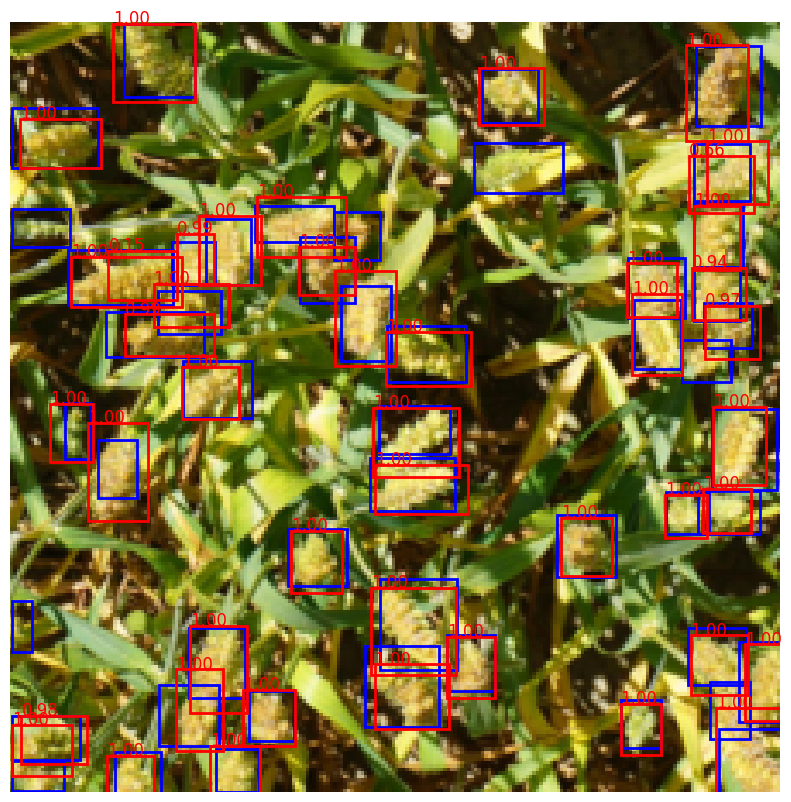

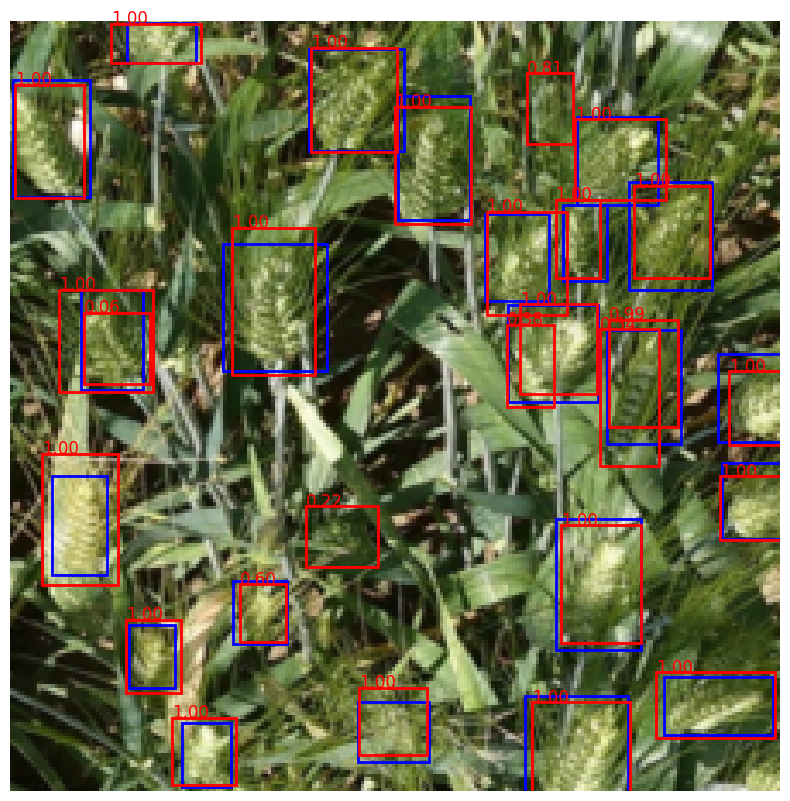

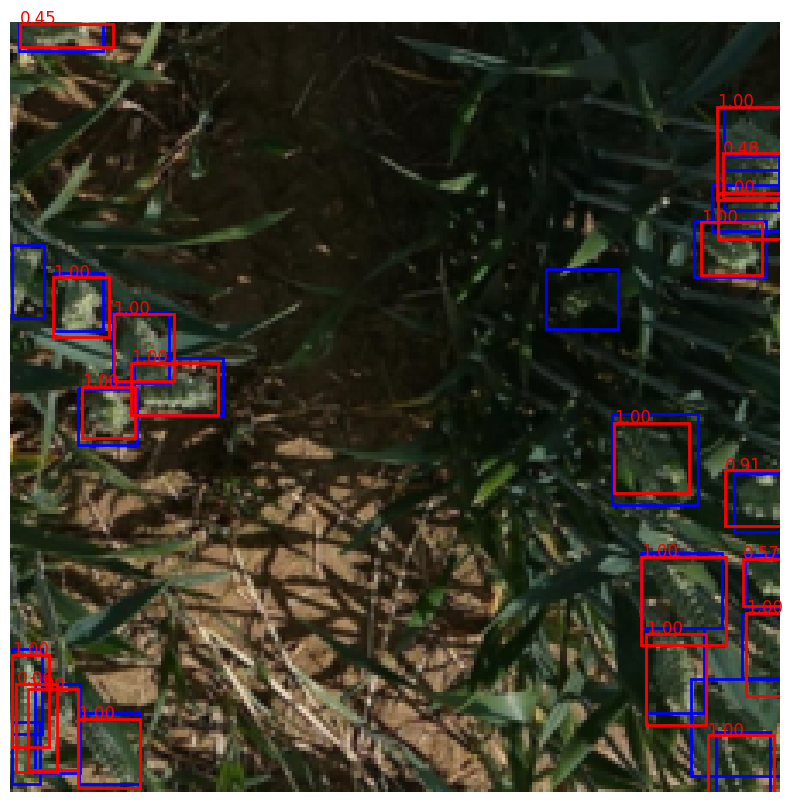

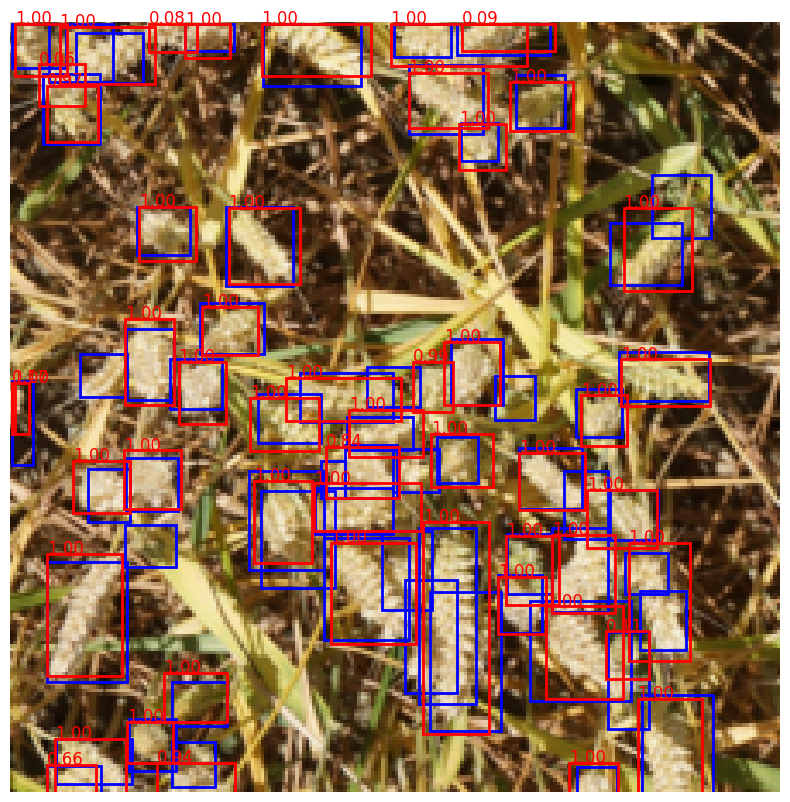

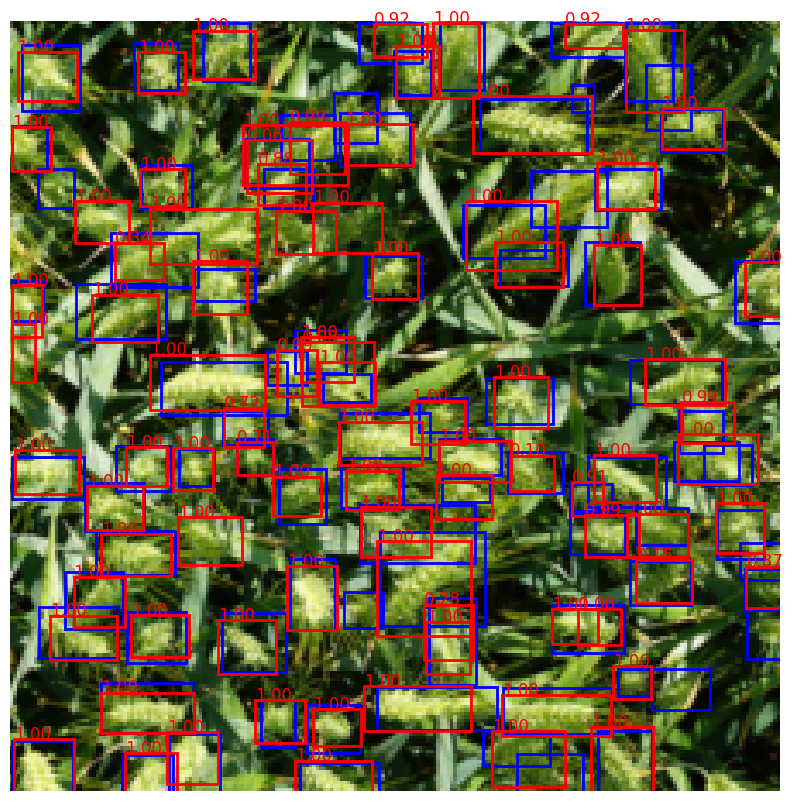

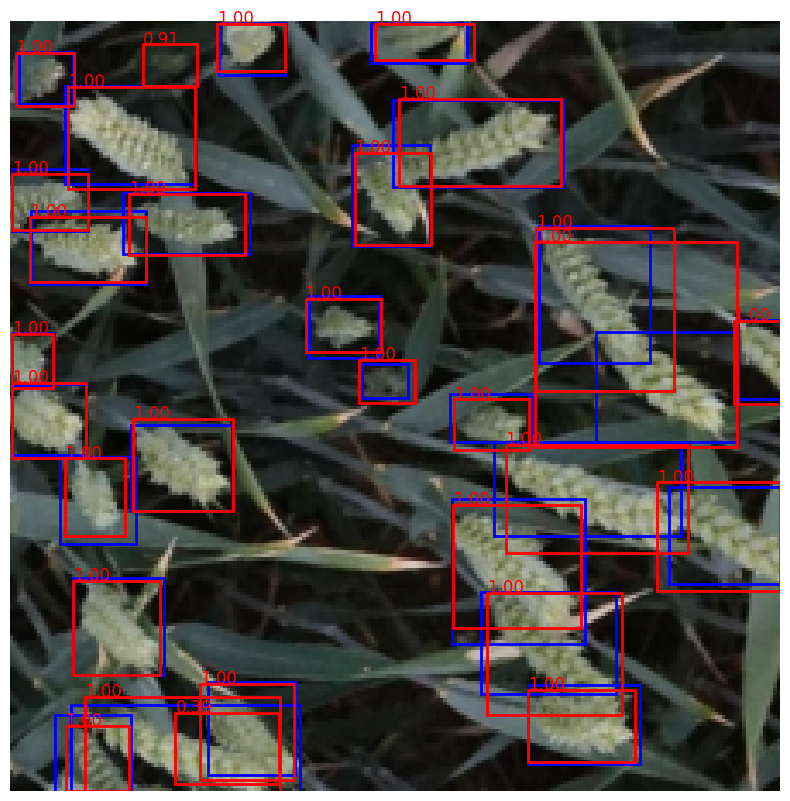

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0060914755..1.0000001].


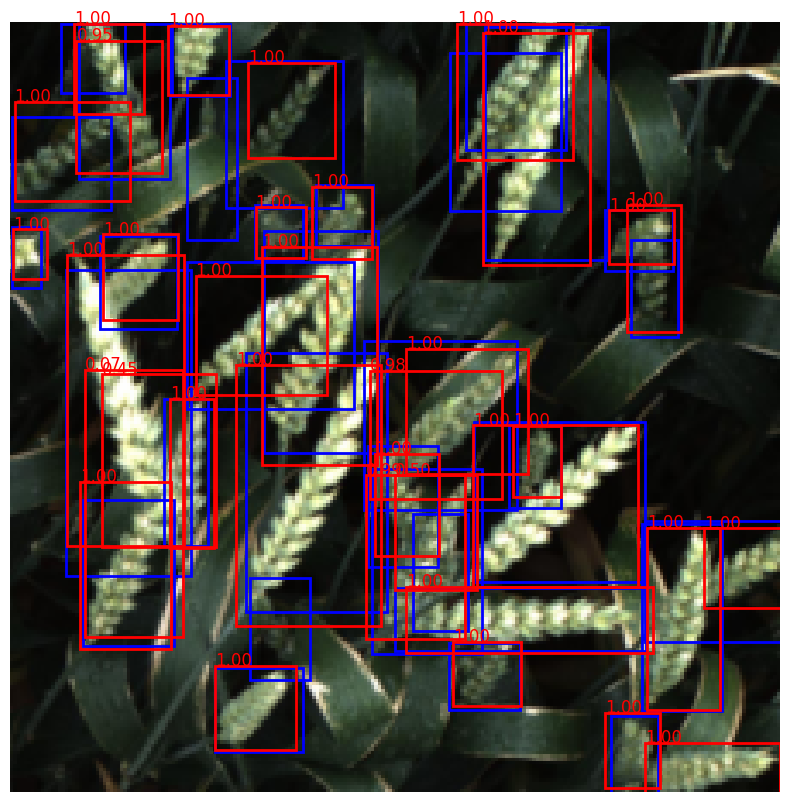

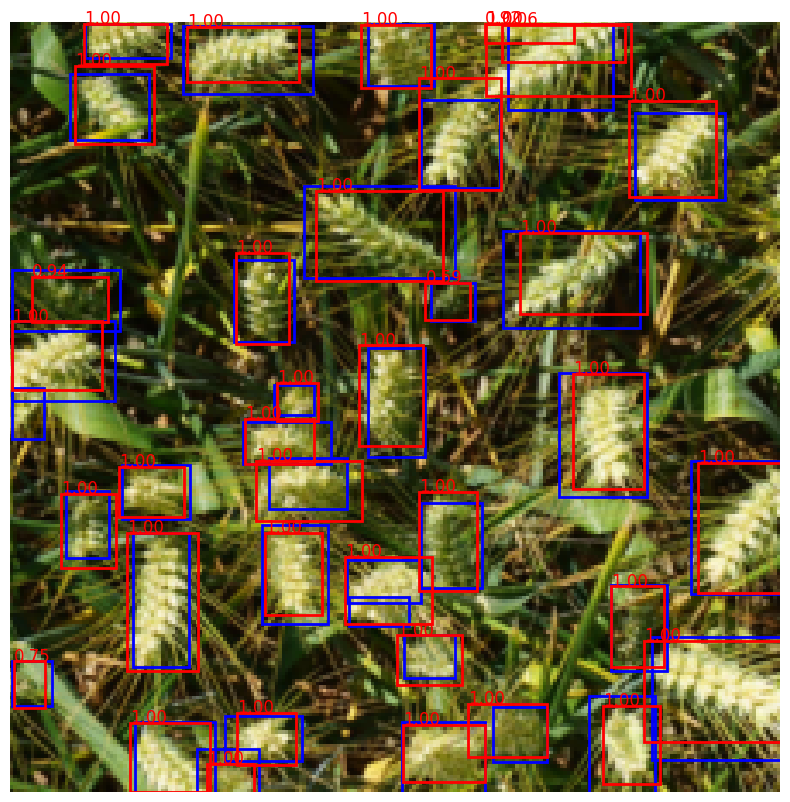

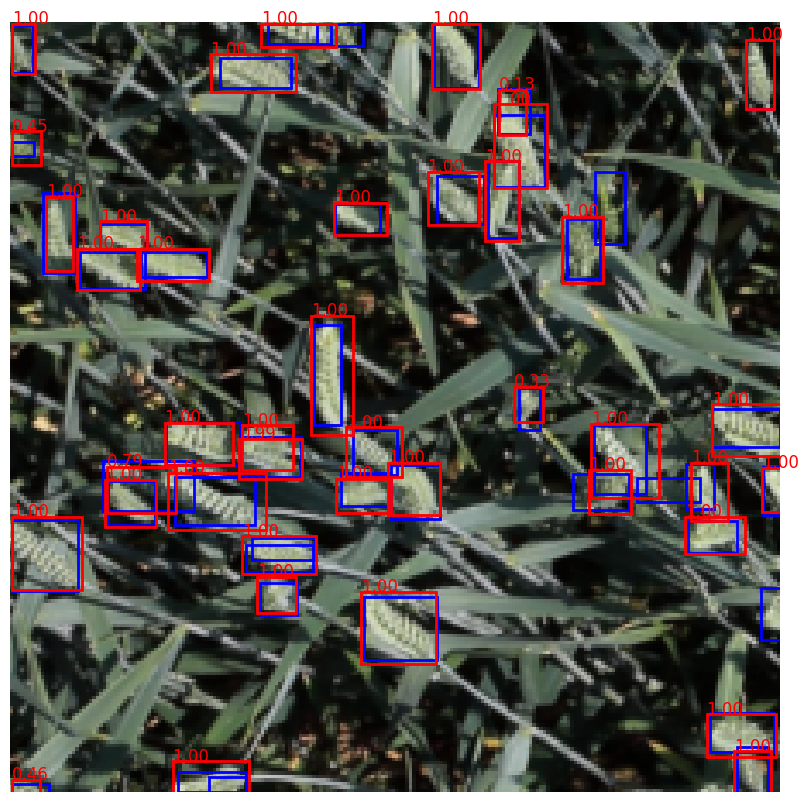

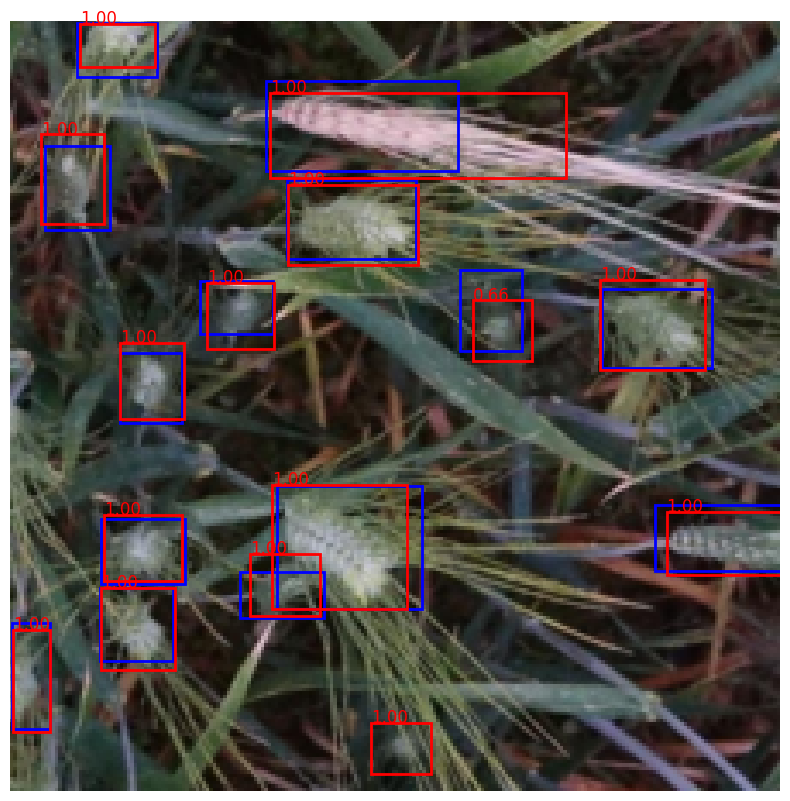

In [37]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def show_target_and_detection(image_tensor, target_bboxes, detected_bboxes, confidence_scores):
    # permute image_tensor (cloned) to (H, W, C) and convert to numpy
    image_tensor = image_tensor.clone().detach()
    image_tensor = image_tensor.squeeze(0)
    image_tensor = image_tensor.permute(1, 2, 0)
    # scale to 0-1 from -1-1
    image_tensor = (image_tensor + 1) / 2
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image_tensor)
    for bbox in target_bboxes:
        x, y, x_max, y_max = bbox
        w = x_max - x
        h = y_max - y
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
    for bbox, score in zip(detected_bboxes, confidence_scores):
        x, y, x_max, y_max = bbox
        w = x_max - x
        h = y_max - y
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"{score:.2f}", fontsize=12, color='r')
    plt.axis('off')
    plt.show()


for pred in predictions:
    image = pred["image"]
    target = pred["target_boxes"]
    output_boxes = pred["pred_boxes"]
    scores = pred["scores"]
    show_target_and_detection(image, target, output_boxes, scores)

As you may have noticed, the images are quite pixelated. We considered using a larger input size, but finally decided against it because we do not want to change the input size of the model to a size, it hasn't been trained on.